## CS310 Natural Language Processing
## Lab 5 (part 1): Training a *n*-gram language model

Install the `nltk` library:
```bash
pip install nltk
```

In [2]:
from pprint import pprint
from typing import List, Tuple

### Read the corpus

This time we use the full text of 《论语》.

In [3]:
# A cleaned corpus is provided

text: List[List[str]] = [] 
with open(f"lunyu_20chapters.txt", "r") as f:
    for line in f:
        line = line.strip()
        text.append(list(line))

# Test result
print(len(text))
print(text[0])
print(text[-1])

512
['子', '曰', '：', '学', '而', '时', '习', '之', '，', '不', '亦', '说', '乎', '？', '有', '朋', '自', '远', '方', '来', '，', '不', '亦', '乐', '乎', '？', '人', '不', '知', '而', '不', '愠', '，', '不', '亦', '君', '子', '乎', '？']
['孔', '子', '曰', '：', '不', '知', '命', '，', '无', '以', '为', '君', '子', '也', '；', '不', '知', '礼', '，', '无', '以', '立', '也', '；', '不', '知', '言', '，', '无', '以', '知', '人', '也', '。']


## T1. Implement bigrams
Try implement the customized `my_bigrams()` function to collect all bigrams from the input text.

In [4]:
def my_bigrams(text: List[str]) -> List[Tuple[str, str]]:
    bigrams = []
    ### START CODE HERE ###
    # 遍历文本，取相邻两个元素组成二元组
    for i in range(len(text) - 1):  # -1 是因为最后一个词没有下一个词
        bigrams.append((text[i], text[i + 1]))  # 添加相邻的二元组
    ### END CODE HERE ###
    return bigrams

# Test result
print('unigrams:', text[0][:8])
print('bigrams:', my_bigrams(text[0][:8]))

### You are expected to see the following output:
# unigrams: ['子', '曰', '：', '学', '而', '时', '习', '之']
# bigrams: [('子', '曰'), ('曰', '：'), ('：', '学'), ('学', '而'), ('而', '时'), ('时', '习'), ('习', '之')]

unigrams: ['子', '曰', '：', '学', '而', '时', '习', '之']
bigrams: [('子', '曰'), ('曰', '：'), ('：', '学'), ('学', '而'), ('而', '时'), ('时', '习'), ('习', '之')]


Using `nltk.util.bigrams`, you should see the same output.

In [5]:
from nltk.util import bigrams

print('bigrams from nltk:', list(bigrams(text[0][:8])))

bigrams from nltk: [('子', '曰'), ('曰', '：'), ('：', '学'), ('学', '而'), ('而', '时'), ('时', '习'), ('习', '之')]


## T2. Count the frequency of bigrams

Using the just defined `my_bigrams()` function, count the frequency of all bigrams throughout 《论语》. Print the top 10 most frequent ones.

*Hint*: `collections.Counter` is useful.

In [ ]:
from collections import Counter

### START CODE HERE ###
all_bigrams = []  # 存放所有的二元组
for line in text:  # 遍历每个句子
    bigrams = my_bigrams(line)  # 只生成当前句子内的二元组
    all_bigrams.extend(bigrams)  # 添加到总列表中
bigrams_freq = Counter(all_bigrams)  # 统计频率
### END CODE HERE ###

pprint(bigrams_freq.most_common(10))

### You are expected to get the following output:
# [(('曰', '：'), 739),
#  (('子', '曰'), 452),
#  (('也', '。'), 187),
#  (('也', '，'), 132),
#  (('君', '子'), 107),
#  (('矣', '。'), 105),
#  (('，', '不'), 104),
#  (('之', '，'), 86),
#  (('，', '子'), 86),
#  (('？', '子'), 81)]

[(('曰', '：'), 739),
 (('子', '曰'), 452),
 (('也', '。'), 187),
 (('也', '，'), 132),
 (('君', '子'), 107),
 (('矣', '。'), 105),
 (('，', '不'), 104),
 (('之', '，'), 86),
 (('，', '子'), 86),
 (('？', '子'), 81)]


### Further Preprocessing Steps

`nltk` provides very useful functions for padding. The default padding token is `"<s"` for the start of sentence and `"</s>"` for the end.

In [9]:
from nltk.lm.preprocessing import pad_both_ends

print('padded with n=2:', list(pad_both_ends(text[0][:8], n=2))) # n=2 for bigrams
print('padded with n=3:', list(pad_both_ends(text[0][:8], n=3))) # n=3 for trigrams


padded with n=2: ['<s>', '子', '曰', '：', '学', '而', '时', '习', '之', '</s>']
padded with n=3: ['<s>', '<s>', '子', '曰', '：', '学', '而', '时', '习', '之', '</s>', '</s>']


To the make more robust we could also train it on a mixture of unigrams, bigrams, and higher order terms. `nltk` once again helpfully provides a function called `everygrams`.

In [ ]:
from nltk.util import everygrams

padded_bigrams = list(pad_both_ends(text[0][:8], n=2))

print('unigrams + bigrams:')
# 可以生成从长度为1的 unigrams 到长度为 max_len 的所有 n-grams。
pprint(list(everygrams(padded_bigrams, max_len=2)))

unigrams + bigrams:
[('<s>',),
 ('<s>', '子'),
 ('子',),
 ('子', '曰'),
 ('曰',),
 ('曰', '：'),
 ('：',),
 ('：', '学'),
 ('学',),
 ('学', '而'),
 ('而',),
 ('而', '时'),
 ('时',),
 ('时', '习'),
 ('习',),
 ('习', '之'),
 ('之',),
 ('之', '</s>'),
 ('</s>',)]


The previous two steps can be combined into the `padded_everygrams_pipeline` function.

In [15]:
from nltk.lm.preprocessing import padded_everygram_pipeline

train, vocab = padded_everygram_pipeline(2, text)

Both the `train` and `vocab` returned are lazy iterators, which are only evaluated on demand at training time.

In [16]:
# Test train and vocab
print(type(train))
print(type(vocab))

<class 'generator'>
<class 'itertools.chain'>


### Training the model

Having the data prepared, we are ready to start training an n-gram model. 

We can simply use the `MLE` class from `nltk`, and specify the highest order n-gram to instantiate it.

In [ ]:
from nltk.lm import MLE
# 基于最大似然估计的 n-gram 模型
lm = MLE(2) # 2 for a bigram model

The training is straight-forward:

In [18]:
# Make sure the two iterators are not used yet; if yes, re-create them

lm.fit(train, vocab)

It's done! Now check out some attributes of `lm`.

In [19]:
print(lm.vocab) # A summary of the vocabulary
print(lm.counts) # A summary of the ngrams and their counts

# Check if words exist in vocabulary
print(lm.vocab.lookup(text[0][:8])) 
print(lm.vocab.lookup(["some", "sample", "words"])) # Unknow words are mapped to <UNK>

### You should expect to see the following output:
# <Vocabulary with cutoff=1 unk_label='<UNK>' and 1355 items>
# <NgramCounter with 2 ngram orders and 41284 ngrams>
# ('子', '曰', '：', '学', '而', '时', '习', '之')
# ('<UNK>', '<UNK>', '<UNK>')

<Vocabulary with cutoff=1 unk_label='<UNK>' and 1355 items>
<NgramCounter with 2 ngram orders and 41284 ngrams>
('子', '曰', '：', '学', '而', '时', '习', '之')
('<UNK>', '<UNK>', '<UNK>')


### Using the trained model

It provides convenient interface to access counts for unigrams and bigrams:

In [20]:
print(lm.counts['子'])
print(lm.counts[['子']]['曰']) # Count of the bigram ('子', '曰')

972
452


`MLE.score()` returns the probability of a word given its context.

In [21]:
print(lm.score('子'))
print(lm.score('子', context=['<s>'])) # P('子' | '<s>')
print(lm.score('曰', context=['子'])) # P('曰' | '子')

0.046511627906976744
0.6796875
0.46502057613168724


`MLE.perplexity()` returns the perplexity of a given sequence of n-grams.
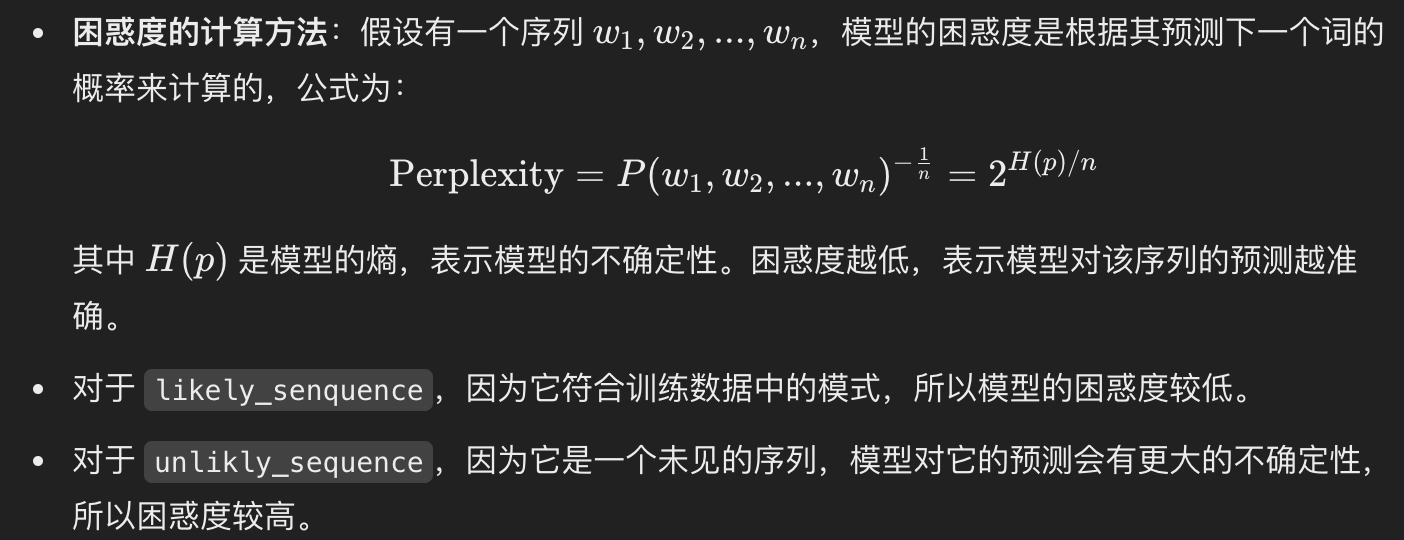

In [ ]:
likely_senquence = [('<s>',), ('<s>', '子'),('子',), ('子', '曰'), ('曰',)] # “<s> 子 曰”
unlikly_sequence = [('<s>',), ('<s>', '曰'),('曰',), ('曰', '子'), ('子',)] # “<s> 曰 子” -- never seen in the training data
# 用来计算给定 n-gram 序列 的困惑度
print(lm.perplexity(likely_senquence))
print(lm.perplexity(unlikly_sequence)) # 未见的序列

9.479500591963152
inf


## T3. Find the most probable/likelihood word given a context

Go through all the words in vocabulary, and find the 10 most probable word given the context "乐" (delightness/joy).

*Hint*: `MLE.vocab` provides the vocabulary.

In [24]:
import math

probs = {}
### START CODE HERE ###
for word in lm.vocab:
    prob = lm.score(word, context=['乐'])
    probs[word] = prob
### END CODE HERE ###

pprint(sorted(probs.items(), key=lambda x: x[1], reverse=True)[:10])

### You are expected to see the following output:
# [('，', 0.25),
#  ('。', 0.10416666666666667),
#  ('不', 0.0625),
#  ('之', 0.041666666666666664),
#  ('乎', 0.041666666666666664),
#  ('、', 0.041666666666666664),
#  ('云', 0.041666666666666664),
#  ('征', 0.041666666666666664),
#  ('而', 0.020833333333333332),
#  ('亦', 0.020833333333333332)]

[('，', 0.25),
 ('。', 0.10416666666666667),
 ('不', 0.0625),
 ('之', 0.041666666666666664),
 ('乎', 0.041666666666666664),
 ('、', 0.041666666666666664),
 ('云', 0.041666666666666664),
 ('征', 0.041666666666666664),
 ('而', 0.020833333333333332),
 ('亦', 0.020833333333333332)]


## Generate a sentence

Use the `MLE.generate()` function to generate a sentence. Try with any context words you like.

This function does automatic greedy search.

In [25]:
lm.generate(10, text_seed=['子'])

['曰', '：', '诵', '《', '诗', '》', '、', '击', '磬', '乎']